# Example: Single Asset Geometric Brownian Motion (GBM) Models
In this example, we will estimate the parameters of a geometric Brownian motion (GBM) model for a single asset, and then use this model to simulate future price paths.

> __Learning Objectives:__
> 
> Fill me in Later.

This is going to be interesting, so let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

>__Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

### Data
We gathered daily open-high-low-close (OHLC) data for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2014` until `12-31-2024`, along with data for a few exchange-traded funds and volatility products during that time period. 

Let's load the `original_dataset::DataFrame` by calling [the `MyTrainingMarketDataSet()` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/data/#VLQuantitativeFinancePackage.MyTrainingMarketDataSet) and remove firms that do not have the maximum number of trading days. The cleaned dataset $\mathcal{D}$ will be stored in the `dataset` variable.

In [2]:
original_dataset = MyTrainingMarketDataSet() |> x-> x["dataset"];

Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or delisting events. Let's collect only those tickers with the maximum number of trading days.

First, let's compute the number of records for a firm that we know has the maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days::Int64` variable:

In [3]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [4]:
dataset = let

    # initialize -
    dataset = Dict{String, DataFrame}();

    # iterate through the dictionary; we can't guarantee a particular order
    for (ticker, data) ∈ original_dataset  # we get each (K, V) pair!
        if (nrow(data) == maximum_number_trading_days) # what is this doing?
            dataset[ticker] = data;
        end
    end
    dataset; # return
end;

Finally, let's get a list of the firms in our cleaned dataset and sort them alphabetically. We store the sorted firm ticker symbols in the `list_of_tickers::Array{String,1}` variable.

In [5]:
list_of_tickers = keys(dataset) |> collect |> sort # list of firm "ticker" symbols in alphabetical order

424-element Vector{String}:
 "A"
 "AAL"
 "AAP"
 "AAPL"
 "ABBV"
 "ABT"
 "ACN"
 "ADBE"
 "ADI"
 "ADM"
 ⋮
 "WYNN"
 "XEL"
 "XOM"
 "XRAY"
 "XYL"
 "YUM"
 "ZBRA"
 "ZION"
 "ZTS"

### Constants
Finally, let's set some constants we'll use later in this notebook. The comments describe the constants, their units, and permissible values.

In [6]:
Δt = (1.0/252.0); # time step
T = 64; # length of simulation -> 1 trading quarter
all_range = range(1,stop=maximum_number_trading_days,step=1) |> collect;

___

## Task 1: Estimate the $\mu$ parameter from data
In this task, we will estimate the drift parameter $\mu$ from historical price data. Given the price observations ${S_{1},\ldots,S_{N}}$, we can construct an __overdetermined__ system of equations:
$$
\begin{align*}
\hat{\mathbf{X}}\mathbf{\theta} + \epsilon &= \mathbf{y}\\
\end{align*}
$$
where $\mathbf{\theta}$ is the parameter vector we want to estimate (the y-intercept $\ln(S_{0})$ and slope $m = \mu$), $\epsilon\sim\mathcal{N}(0,\sigma_{\epsilon}^{2})$ is an error model, $\mathbf{X}$ is the $N\times{2}$ design matrix, and $\mathbf{y}$ is the $N\times{1}$ observation vector. The design matrix $\mathbf{X}$ is given by:
$$
\begin{align*}
\hat{\mathbf{X}} &= \begin{bmatrix}
1 & 1\Delta{t} \\
1 & 2\Delta{t} \\
\vdots & \vdots \\
1 & N\Delta{t}
\end{bmatrix}\\
\end{align*}
$$
while the observation vector $\mathbf{y}$ is given by:
$$
\begin{align*}
\mathbf{y} &= \begin{bmatrix}
\ln(S_{1}) \\
\ln(S_{2}) \\
\vdots \\
\ln(S_{N})
\end{bmatrix}\\
\end{align*}
$$
The unknown (expected) parameter vector estimate $\hat{\mathbf{\theta}}$ has an analytical solution given by the normal equations:
$$
\boxed{
\begin{align*}
\hat{\mathbf{\theta}} &= (\hat{\mathbf{X}}^{\top}\hat{\mathbf{X}})^{-1}\hat{\mathbf{X}}^{\top}\mathbf{y}\quad\blacksquare\\
\end{align*}}
$$


In [7]:
θ̂_dictionary = let

    # initialize -
    data = Dict{String, NamedTuple}();

    for ticker ∈ eachindex(list_of_tickers)
        firm_ticker = list_of_tickers[ticker];
        firm_data = dataset[firm_ticker];
        T_all = all_range*Δt .- Δt;

        A = [ones(maximum_number_trading_days) T_all];
        Y = log.(firm_data[!,:volume_weighted_average_price]);

        # Solve the normal equations
        θ = inv(transpose(A)*A)*transpose(A)*Y;

        # store the results in a named tuple -
        data[firm_ticker] = (b = θ[1], m = θ[2]);
    end
    data; # return
end

Dict{String, NamedTuple} with 424 entries:
  "EMR"  => (b = 3.92437, m = 0.0644198)
  "CTAS" => (b = 2.69144, m = 0.235649)
  "HSIC" => (b = 3.95725, m = 0.0386116)
  "KIM"  => (b = 3.12273, m = -0.0208058)
  "PLD"  => (b = 3.60571, m = 0.132629)
  "IEX"  => (b = 4.2588, m = 0.123906)
  "BAC"  => (b = 2.75484, m = 0.0930762)
  "CBOE" => (b = 4.0031, m = 0.107147)
  "EXR"  => (b = 4.0407, m = 0.109955)
  "NCLH" => (b = 4.107, m = -0.119297)
  "CVS"  => (b = 4.45628, m = -0.0196272)
  "DRI"  => (b = 3.97448, m = 0.111374)
  "DTE"  => (b = 4.42641, m = 0.0416772)
  "ZION" => (b = 3.42861, m = 0.0486871)
  "AVY"  => (b = 3.90957, m = 0.148483)
  "EW"   => (b = 2.98773, m = 0.171359)
  "EA"   => (b = 3.95994, m = 0.111369)
  "NWSA" => (b = 2.51942, m = 0.0508625)
  "CAG"  => (b = 3.6385, m = -0.0186004)
  ⋮      => ⋮

### Check: Is the actual residual `normally` distributed?
We assumed that the error model `ϵₙ,` which describes the portion of the data not captured by the deterministic share price expression, was `Normally` distributed. Let's plot the actual density `ϵ` of the residuals and a `Normal` error model to see how well they match:

In [8]:
 ϵ, ϵₙ, rand_firm_ticker, A, Y = let
    rand_firm_ticker = rand(list_of_tickers)
    firm_data = dataset[rand_firm_ticker]
    T_all = all_range*Δt .- Δt;
    A = [ones(maximum_number_trading_days) T_all];
    Y = log.(firm_data[!,:volume_weighted_average_price]);
    
    θ = [
        θ̂_dictionary[rand_firm_ticker].b, # intercept
        θ̂_dictionary[rand_firm_ticker].m # slope
    ];

    ϵ = Y .- A*θ
    ϵₙ = fit_mle(Normal,ϵ);

    (ϵ, ϵₙ, rand_firm_ticker, A, Y); # return
end;

Fill me in.

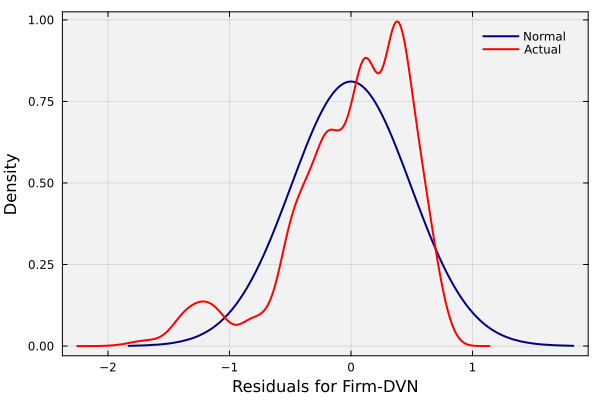

In [9]:
let 
    
    plot(ϵₙ, label="Normal", c=:navyblue,lw=2)
    density!(ϵ, normalize=true, xlabel="Residuals for Firm-$(rand_firm_ticker)", 
        ylabel="Density", label="Actual", c=:red,lw=2)

    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);

end

#### Anderson-Darling Test
The actual and model residual plots may look similar or different, depending on the random `ticker` that was selected.
One approach to answering this question more rigorously is to perform a one-sample [Anderson–Darling test](https://en.wikipedia.org/wiki/Anderson–Darling_test), exported by the [HypthesisTests.jl package](https://juliastats.org/HypothesisTests.jl/stable/), of the `H0: null hypothesis` that the actual residual `ϵ` is drawn from the distribution `ϵₙ` against the `H1:alternative hypothesis` that the sample is not drawn from distribution `ϵ.`
* `reject` the `H0: null hypothesis,` i.e., the `actual` residual `ϵ`  and `ϵₙ` are from different distributions, if the `pvalue`$\leq$`0.05`. We might consider using a different error model in future applications for this `ticker.`

In [10]:
AD_test_result = OneSampleADTest(ϵ,ϵₙ)

One sample Anderson-Darling test
--------------------------------
Population details:
    parameter of interest:   not implemented yet
    value under h_0:         NaN
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: reject h_0
    one-sided p-value:           <1e-06

Details:
    number of observations:   2767
    sample mean:              1.2223286672273499e-15
    sample SD:                0.4919709987055598
    A² statistic:             51.52051677030455


### Check: How well does the deterministic model describe the VWAP trajectory?
Before we estimate the volatility parameter $\sigma$, let's look at how well the VWAP is replicated using only the deterministic portion of the GBM model and how uncertainty in $\mu$ influences the simulation.

> __Sampling__: Let's compute the predicted share price $\hat{\mathbf{Y}}$ where we sample the error model $\epsilon_{n}$ to compute possible values for $\theta$, and then compute the share price values. Store the predicted share prices in the `error_simulation_array` variable.

So what do we see?

In [11]:
error_simulation_array = let
    N = 1000;
    
    error_simulation_array = Array{Float64,2}(undef,maximum_number_trading_days,N);
    for i ∈ 1:N
        error = rand(ϵₙ,maximum_number_trading_days)
        θᵢ = inv(transpose(A)*A)*transpose(A)*Y + inv(transpose(A)*A)*transpose(A)*error
        Ŷᵢ = A*θᵢ
        for k ∈ 1:maximum_number_trading_days
            error_simulation_array[k,i] =  Ŷᵢ[k]
        end
    end

    error_simulation_array;
end

2767×1000 Matrix{Float64}:
 3.72122  3.72857  3.75559  3.76226  …  3.72666  3.69436  3.72248  3.71155
 3.72115  3.72848  3.7555   3.76216     3.72658  3.69431  3.72239  3.7115
 3.72108  3.72839  3.7554   3.76207     3.7265   3.69425  3.72231  3.71145
 3.72102  3.7283   3.75531  3.76197     3.72642  3.6942   3.72223  3.7114
 3.72095  3.72822  3.75521  3.76188     3.72634  3.69415  3.72215  3.71135
 3.72089  3.72813  3.75512  3.76178  …  3.72625  3.69409  3.72207  3.7113
 3.72082  3.72804  3.75502  3.76169     3.72617  3.69404  3.72199  3.71125
 3.72075  3.72795  3.75493  3.76159     3.72609  3.69398  3.7219   3.71119
 3.72069  3.72786  3.75484  3.7615      3.72601  3.69393  3.72182  3.71114
 3.72062  3.72777  3.75474  3.7614      3.72593  3.69388  3.72174  3.71109
 ⋮                                   ⋱                             
 3.53871  3.48496  3.49597  3.49917     3.50499  3.54476  3.4977   3.57
 3.53865  3.48487  3.49587  3.49907     3.50491  3.5447   3.49762  3.56995
 3.53858  3

`Unihide` the code block below to see how we compute and plot the expected value and the uncertainty $\hat{\sigma}$ of the expected value of the VWAP. We plot $\pm~{3.291}\cdot\hat{\sigma}$ in `gray` (the `99.9%` confidence interval) around the expected deterministic VWAP value $\mu$ shown in `red.`
> __Summary__: The deterministic price model parameterized with the growth rate $\mu$ tracks the central trend of the `VWAP`. However, the deterministic model does describe the random fluctuations observed around the price. To account for the randomness, we must include the model's random component, which requires estimating the volatility parameter $\sigma$, which modifies the noise term.

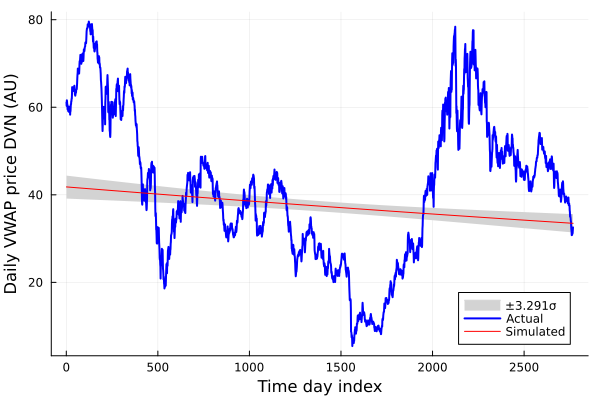

In [12]:
let
    
    θ = [
        θ̂_dictionary[rand_firm_ticker].b, # intercept
        θ̂_dictionary[rand_firm_ticker].m # slope
    ];
    
    
    Ŷ = A*θ;
    mean_value = mean(exp.(error_simulation_array),dims=2);
    std_value = std(exp.(error_simulation_array),dims=2);
    plot(mean_value,fillrange=(mean_value .+ 3.291*std_value), label="±3.291σ", c=:lightgray)
    plot!(mean_value,fillrange=(mean_value .- 3.291*std_value), label="", c=:lightgray)
    plot!(exp.(Y),c=:blue,lw=2, label="Actual")
    plot!(exp.(Ŷ),c=:red,lw=1, label="Simulated")
    xlabel!("Time day index", fontsize=18);
    ylabel!("Daily VWAP price $(rand_firm_ticker) (AU)", fontsize=18)
end

### Curious: Why is the uncertainty region curved?
The uncertainty region around the mean deterministic price prediction is curved. This comes about because the noise model will [perturb both the slope and the intercept of the regression line](https://stats.stackexchange.com/questions/85560/shape-of-confidence-interval-for-predicted-values-in-linear-regression). 

`Unihide` the code block below to see how we plotted individual estimated best-fit lines for the parameter vector $\theta$.

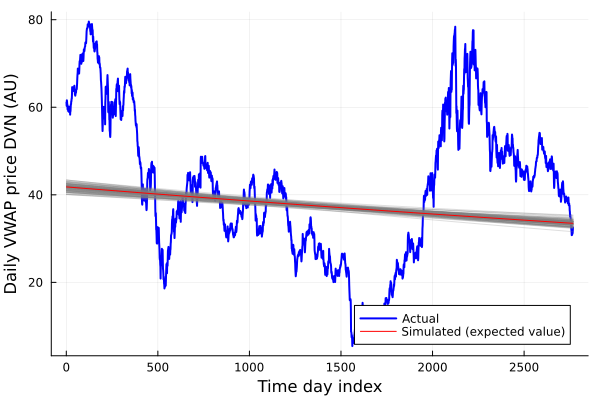

In [13]:
let

    N = 1000;
    θ = [
        θ̂_dictionary[rand_firm_ticker].b, # intercept
        θ̂_dictionary[rand_firm_ticker].m # slope
    ];


    Yₘ = A*θ;
    skip = 10;
    plot(exp.(Y),c=:blue,lw=2, label="Actual")
    mean_value = mean(exp.(error_simulation_array),dims=2);
    for i ∈ 1:skip:N
        Ŷ = error_simulation_array[:,i];
        plot!(exp.(Ŷ), c=:gray50, label="", alpha=0.25)
    end
    current()
    plot!(exp.(Yₘ),c=:red,lw=1, label="Simulated (expected value)")
    xlabel!("Time day index", fontsize=18);
    ylabel!("Daily VWAP price $(rand_firm_ticker) (AU)", fontsize=18)
end

## Task 2: Estimate the returns and volatility parameter $\sigma$ from data.
Estimate the volatility parameter $\sigma$ from historical data for all firms in the `dataset` $\mathcal{D}$ using a `for` loop. First, compute the log growth rates for the firms in the `list_of_all_firms` $\mathcal{L}$ using the `log_return_matrix(...)` function.

[The `log_return_matrix(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.log_growth_matrix) takes `dataset` $\mathcal{D}$ and a list of firms $\mathcal{L}$ and computes the growth rate values for each firm as a function of time. The data is returned as a $\left(\dim\mathcal{D}_{i} - 1\right)\times\dim\mathcal{L}$ array (time on the rows, firms on the columns). We store the data in the `log_growth_array::Array{Float64,2}` variable:

In [14]:
log_growth_array = log_growth_matrix(dataset, list_of_tickers);

### Estimate the volatility parameter $\sigma$
Let's estimate the volatility parameter $\sigma$, i.e., the standard deviation of the return.
First, we define the `σ̂_dictionary::Dict{String, Float64}`, which will hold estimates of the annualized volatility parameters for each firm as `key`$\rightarrow$`value` pairs, where `key` is the `ticker` and the `value` is the annualized volatility value. 

For each firm $i$, we:
* Select a column from `log_growth_array,` get the corresponding `ticker` for firm $i$, and check if this firm has normally distributed returns using the `is_return_normal_dictionary` dictionary.
    * __Normal__: If the return is normally distributed,  we fit the return data to a `Normal` distribution `d` using [maximum likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation)
    * __Not Normal__:if the return is `NOT` normal, we fit the return data to a `Laplace` distribution `d` using [maximum likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation)
* We compute an estimate of the __annualized historical volatility__ as $\bar{\sigma}\cdot\sqrt{252}$ from the distribution `d`. We access the variance of `d` using [the `params(...)` function from the Distributions.jl](https://github.com/JuliaStats/Distributions.jl.git) package.

In [15]:
σ̂_dictionary = Dict{String,Float64}();
for i ∈ eachindex(list_of_tickers)
    
    firm_ticker = list_of_tickers[i];
    firm_data = dataset[firm_ticker];
    samples = log_growth_array[:,i];
    R = samples.*Δt; # hmmm: what is going on here?
    d = fit_mle(Normal, R);
    σ̂_dictionary[firm_ticker] = params(d) |> last |> x-> *(x, sqrt(252)); # annualize
end
σ̂_dictionary;

#### Save the estimated drift and volatility parameters to a file

In [16]:
parameters_df = DataFrame();
for i ∈ eachindex(list_of_tickers)
    
    firm_ticker = list_of_tickers[i];
    μ̂ = θ̂_dictionary[firm_ticker].m;
    σ̂ = σ̂_dictionary[firm_ticker];
    
    data_tuple = ( 
        ticker = firm_ticker,
        drift =  μ̂,
        volatility = σ̂
    );
    
    push!(parameters_df, data_tuple)
end
findfirst(x->x=="SPY",parameters_df[:,:ticker]) |> i-> parameters_df[i,:]

DataFrameRow
 Row │ ticker  drift     volatility 
     │ String  Float64   Float64    
─────┼──────────────────────────────
 350 │ SPY     0.103145    0.135096

In [17]:
CSV.write(joinpath(_PATH_TO_DATA,"Parameters-SP500-2014-2024.csv"), parameters_df);

## Task 3: Visualize the simulation of a random firm for a random period
Now that we have $(\hat{\mu}, \hat{\sigma})$ estimates for each firm in `dataset` $\mathcal{D}$, we can run simulations to see how the single asset GBM performs. 

Let's begin by selecting a `random_firm_index` from our list of firms $\mathcal{L}$, get its price data, and store this in the `random_firm_data` variable:

In [18]:
random_firm_ticker = rand(list_of_tickers)
random_firm_data = dataset[random_firm_ticker];
println("The (randomly) selected firm in this study: $(random_firm_ticker)")

The (randomly) selected firm in this study: LH


Next, randomly choose a contiguous time window of `T` days and analyze the model’s performance during this period. To begin, randomly generate the `start_index` variable, i.e., the trading index, to start the simulation. The `stop_index` will then be determined by adding the number of trading days `T` to the `start_index`:

In [19]:
start_index = rand(1:(maximum_number_trading_days - T - 1))
stop_index = start_index + T
println("Visualize Firm-$(random_firm_ticker) between trading days ($(start_index) -> $(stop_index))")

Visualize Firm-LH between trading days (232 -> 296)


Next, get the $(\hat{\mu},\hat{\sigma})$ values from the respective dictionaries for the `random_firm_index`:

In [20]:
μ̂ = θ̂_dictionary[random_firm_ticker].m;
σ̂ = σ̂_dictionary[random_firm_ticker];
println("Firm-$(random_firm_ticker) has (μ̂,σ̂) = ($(μ̂),$(σ̂))")

Firm-LH has (μ̂,σ̂) = (0.08714074866015623,0.2320615801764991)


### Generate sample price trajectories for a GBM model
Create an instance of [the `MyGeometricBrownianMotionEquityModel` type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyGeometricBrownianMotionEquityModel) using a custom [build function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MyGeometricBrownianMotionEquityModel},%20NamedTuple}). 
* __build method__: We pass the kind of thing we want to build, i.e., [a `MyGeometricBrownianMotionEquityModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyGeometricBrownianMotionEquityModel) to the [the `build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MyGeometricBrownianMotionEquityModel},%20NamedTuple}), along with the growth and volatility parameters, and [the `build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MyGeometricBrownianMotionEquityModel},%20NamedTuple}) returns the GBM model instance, which we store in the `model::MyGeometricBrownianMotionEquityModel` variable.

In [21]:
model = build(MyGeometricBrownianMotionEquityModel, (
            μ = μ̂, σ = σ̂ ));

Then we solve the model between `T₁` and `T₂` starting with price `Sₒ` using [the `sample(…)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyGeometricBrownianMotionEquityModel,%20NamedTuple}) for `number_of_paths::Int64` sample paths. 

In [22]:
Sₒ = random_firm_data[start_index,:volume_weighted_average_price];
T₁ = start_index*Δt
T₂ = stop_index*Δt
X = VLQuantitativeFinancePackage.sample(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt), 
    number_of_paths = 100);

In addition to the numerical samples, we have analytical expressions for both the expected value and the variance of the share price. We've implemented the analytical expectation and variance calculations in the `𝔼(...)` and `Var(...)` functions. Let's call these functions to get analytical values for the expectation_arra and variance of the `VWAP.`

In [23]:
expectation_array = expectation(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt));
variance_array = variance(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt));

`Unhide` the block below to see how to plot the expected value and the variance of the simulated share price versus the actual shore price, as well as the sampled trajectories.

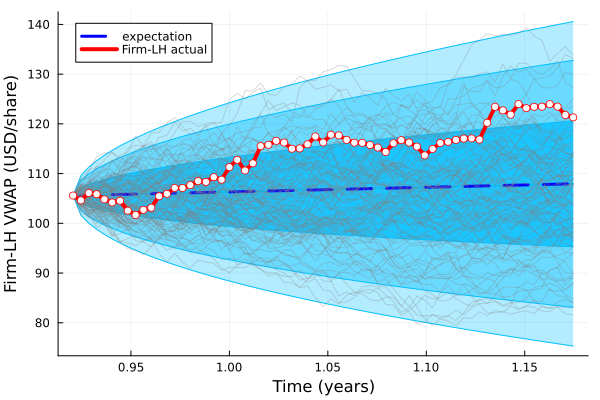

In [ ]:
let
    
    # Initialize -
    L68 = expectation_array[:,2] .- sqrt.(variance_array[:,2])
    U68 = expectation_array[:,2] .+ sqrt.(variance_array[:,2])
    L95 = expectation_array[:,2] .- 1.96*sqrt.(variance_array[:,2])
    U95 = expectation_array[:,2] .+ 1.96*sqrt.(variance_array[:,2])
    L99 = expectation_array[:,2] .- 2.576*sqrt.(variance_array[:,2])
    U99 = expectation_array[:,2] .+ 2.576*sqrt.(variance_array[:,2])

    plot(expectation_array[:,1], expectation_array[:,2], fillrange=L68, c=:deepskyblue1, alpha=0.75, label="")
    plot!(expectation_array[:,1], expectation_array[:,2], fillrange=U68, c=:deepskyblue1, alpha=0.75, label="")
    plot!(expectation_array[:,1], expectation_array[:,2], fillrange=L95, c=:deepskyblue1, alpha=0.4, label="")
    plot!(expectation_array[:,1], expectation_array[:,2], fillrange=U95, c=:deepskyblue1, alpha=0.4, label="")
    plot!(expectation_array[:,1], expectation_array[:,2], fillrange=L99, c=:deepskyblue1, alpha=0.3, label="")
    plot!(expectation_array[:,1], expectation_array[:,2], fillrange=U99, c=:deepskyblue1, alpha=0.3, label="")

    plot!(expectation_array[:,1], expectation_array[:,2],c=:blue, lw=3,ls=:dash, label="expectation")
    plot!(expectation_array[:,1], L68, c=:deepskyblue1, lw=1, label="")
    plot!(expectation_array[:,1], U68, c=:deepskyblue1, lw=1, label="")
    plot!(expectation_array[:,1], L95, c=:deepskyblue1, lw=1, label="")
    plot!(expectation_array[:,1], U95, c=:deepskyblue1, lw=1, label="")
    plot!(expectation_array[:,1], L99, c=:deepskyblue1, lw=1, label="")
    plot!(expectation_array[:,1], U99, c=:deepskyblue1, lw=1, label="")
    plot!(X[:,1],X[:,2:end], label="", c=:gray, alpha=0.3)
    plot!(X[:,1], random_firm_data[start_index:stop_index, :volume_weighted_average_price], lw=4, c=:red, 
        label="Firm-$(random_firm_ticker) actual")
     scatter!(X[1:end,1], random_firm_data[start_index:stop_index, :volume_weighted_average_price], label="", 
         msc=:red, mc=:white)


    xlabel!("Time (years)", fontsize=18)
    ylabel!("Firm-$(random_firm_ticker) VWAP (USD/share)", fontsize=18)
end

#### Check: Was this a successful GBM simulation?
Determining whether a model accurately represents data can be done in various ways, but we will utilize a simple, straightforward functional test. 

> __Functional test__
> 
> * __Success__: If the simulated price falls within a specified lower bound ($L_{j}$) and upper bound ($U_{j}$) for all times $t_j$ within a given interval ($t_{j}\in\mathcal{I}_{k}$), then the model is deemed a `success.`
> * __Failure__: However, if the actual price exceeds the given bounds __at any point__, the simulation is considered a `failure.`

So, did we succeed or fail (for this ticker and time period)?

In [25]:
let
    z = 2.576;
    L = expectation_array[:,2] .- z*sqrt.(variance_array[:,2])
    U = expectation_array[:,2] .+ z*sqrt.(variance_array[:,2])
       
    # check the bounds: if below L, or above U then the simulation failed
    success_flag = true;
    for k ∈ 1:T
        if (random_firm_data[start_index+k-1,:volume_weighted_average_price] < L[k]) || (random_firm_data[start_index+k-1,:volume_weighted_average_price] > U[k])
            success_flag = false;
            break;
        end
    end
    
    println("The simulation of the VWAP of Firm-$(random_firm_ticker) between ($(start_index) -> $(stop_index)) was successful: $(success_flag)")
end

The simulation of the VWAP of Firm-LH between (232 -> 296) was successful: true


## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.